In [0]:
 
'''
Colab or Local Settings
'''

colab = True
colab_import = False
augment_data = False

test_data_path = None
data_root = None
aug_data = None
val_data = None
predict_save_path = None
trial_num = 0

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    if colab_import:
        import subprocess
        subprocess.call(
            ["rsync", 
             '-arvz',
             '--ignore-existing', 
             '--exclude',  """ "Results-C1" """,
             '/content/drive/My Drive/ECE542_sp20_CompetitionData/', 
             './'
             ]
        )
        data_root = './'
        train_data1 = './TrainData-C1/'
        train_data2 = './TrainData-C2/'
        aug_data = './aug_training/'
        val_data = '.val_data/'
        test_data_path = './TestData/'
    else:
        data_root = '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/'
        val_data = '/content/drive/My Drive/ECE 542 Competition Project/ECE 542 Competition Project/val_data/'
        aug_data = '/content/drive/My Drive/ECE 542 Competition Project/ECE 542 Competition Project/aug_training/'
        test_data_path = '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/'      
    predict_save_path = "/content/drive/My Drive/ECE 542 Competition Project/predictions/predict.csv"
else:
    data_root = './'
    aug_data = './aug_training/'
    val_data = './val_data/'
    test_data_path = './TestData/'
    predict_save_path = './predictions/predict.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Load Data and Annotations
import pandas as pd
import numpy as np
import os
from keras.utils import to_categorical
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

#annotations_df = pd.read_csv(data_root + '/TrainAnnotations.csv')
im_path = data_root + "/TrainData-C2/"


def csv_to_list(filepath):
  df = pd.read_csv(filepath)
  return df.values.tolist()

def get_images_and_labels(data_list):
  global im_path
  filepaths, labels = map(list, zip(*data_list)) #generates two lists from a list of two element lists
  num_images = len(labels)
  
  images = [ cv2.imread(os.path.join(im_path, f)) for f in filepaths ] 
  
  return images, labels

def random_square_crop_img(image):    
    height = image.shape[0]
    width = image.shape[1]

    small_dim = min([height, width])
    size = random.randint(224, small_dim)
    
    c = random.randint(0, width - size)
    r = random.randint(0, height - size)

    cropped = image[r:r+size, c:c+size]

    return cropped

def augment_pipeline(
    data_list, 
    augment_args, 
    augment = True, 
    random_crop = True, 
    dsize = (224,224), 
    images_per_class=512, 
    num_random_crops=5, 
    gaussian_noise=True, 
    noise_sd=0.1
    ):
    
    images, labels = get_images_and_labels(data_list)

    # random crop
    if random_crop:
        expanded_images = []
        expanded_labels = [] 
        for i in range(len(images)):
            img = images[i]
            lab = labels[i]
            for i in range(num_random_crops): #replace image with random crops
                expanded_images.append(random_square_crop_img(img))
                expanded_labels.append(lab)
        images = expanded_images
        labels = expanded_labels

    # Color Ordering to RGB
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

    # resize images
    images = [cv2.resize(image, dsize=dsize, interpolation=cv2.INTER_CUBIC) for image in images]
    if gaussian_noise:
      noisy_images = []
      for image in images:
        noise = np.random.normal(0, noise_sd, [dsize[0], dsize[1], 3])
        image = image + noise
        noisy_images.append(image)
      images = noisy_images
    
    if augment:
        #separate images into classes
        img_class_dict = {
            0:[],
            1:[],
            2:[],
            3:[],
            4:[]
        }

        for i in range(len(labels)):
            img_class_dict[labels[i]].append(images[i])

        # Image Augmentation with Keras
        images = []
        labels = []
        imgen = ImageDataGenerator(**augment_args)
        
        for key in img_class_dict.keys():
            class_images = img_class_dict[key]
            class_images = np.asarray(class_images, np.float64)
            try:
              imgen.fit(class_images)
            except:
              print(class_images.shape)
              for key in img_class_dict.keys():
                print(len(img_class_dict[key]))
            batch_gen = imgen.flow(x = class_images, batch_size=32) # batch_size is 32 by default
            img_list = []
            while len(img_list) < images_per_class:
                img_list.extend(next(batch_gen))
            print("Gen Size: {}".format(len(img_list)))
            images.extend(img_list)
            labels.extend([key for i in range(len(img_list))])
        
        # Final shuffle
        temp = list(zip(images, labels))
        random.shuffle(temp)
        images, labels = zip(*temp)

    #convert to trainable form
    images = np.asarray(images)
    labels = to_categorical(labels)
    return images, labels
                       

Text(0, 0.5, 'Count')

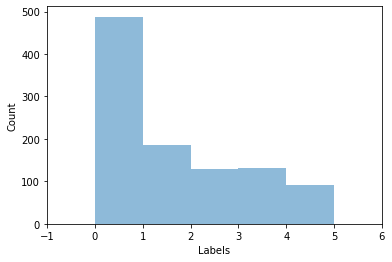

In [0]:
# Examining Augmented Data 

# Label Histogram
import numpy as np
from matplotlib import pyplot as plt

data = csv_to_list(data_root + 'TrainAnnotations.csv')

images, labels = map(list, zip(*data))


bins = np.arange(-1,7,1)
plt.xlim([-1,6])

plt.hist(labels, bins=bins, alpha = 0.5)
plt.xlabel('Labels')
plt.ylabel('Count')

From the histogram, it can be determined that the data is heavily biased towards 0 labels/healthy plants.

In [0]:
### Base Convolutional Network
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
import cv2

trial = 3
model_path = None

if colab:
    model_path = "/content/drive/My Drive/ECE 542 Competition Project/models/trial-" + str(trial)+ '/'
    pretrained_weight_path = ''
else:
    model_path = './models/trial-' + str(trial) + '/'

def generate_model():
  
  #Xception Base with imagenet weights
  
  transfer_base = applications.ResNet101(weights='imagenet', include_top=False)
  x = transfer_base.output
  x = GlobalAveragePooling2D()(x)
  predictions = Dense(256, activation='relu')(x)
  predictions = Dropout(0.6)(predictions)
  predictions = Dense(5, activation='softmax')(predictions)

  model = Model(transfer_base.input, predictions)

  for layer in transfer_base.layers:
    layer.trainable = False
  return model

model = generate_model()
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# Split Data into folds and pseudo testing set
from sklearn.model_selection import train_test_split
import random
# get filepaths and labels
data_list = csv_to_list(data_root + 'TrainData-C2/TrainAnnotations.csv')
random.shuffle(data_list)
# Split into hyperparameter set and test set. Force test set to be equally distributed
test_set_split = 0.3
test_class_size = int(test_set_split*len(data_list)/5)
pseudo_test_set = []

img_class_dict = {
            0:[],
            1:[],
            2:[],
            3:[],
            4:[]
        }

for i in range(len(data_list)):
  img_class_dict[data_list[i][1]].append(data_list[i])

hyperparameter_set = list(data_list)
for key in img_class_dict.keys():
  print(len(img_class_dict[key]))
  for i in range(test_class_size):
    data_tuple = img_class_dict[key][i]
    hyperparameter_set.remove(data_tuple)
    pseudo_test_set.append(data_tuple)
random.shuffle(hyperparameter_set)
random.shuffle(pseudo_test_set)

print(len(hyperparameter_set))
print(len(pseudo_test_set))
print(data_list)
print(hyperparameter_set)
print(pseudo_test_set)

# manual k folds
# Splitting folds manually to avoid double dipping in randomly generated data
k = 5
num_in_split = int(len(hyperparameter_set)/k)
folds = []
for i in range(k):
  fold = hyperparameter_set[:num_in_split]
  hyperparameter_set = hyperparameter_set[num_in_split:]
  folds.append(fold)

# Run data augmentatio

hyperparameter_augment_args = {
            'featurewise_center': False, # Default False
            'samplewise_center': False, # Default False
            'featurewise_std_normalization': False, # Default False
            'samplewise_std_normalization': False, # Default False
            'zca_whitening': False, # Default False
            'zca_epsilon': 1e-06, # Default 1e-6
            'rotation_range': 30,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'brightness_range': None, # Default None
            'shear_range': 10.0,
            'zoom_range': 0.2,
            'channel_shift_range': 0.0,
            'fill_mode': 'reflect', # Default 'nearest'
            'cval': 0.0,
            'horizontal_flip': True, # Default False
            'vertical_flip': False, # Default False
            'rescale': None # Default None
        }

#Test Data Augmentation
#pseudo_test_set_images, psuedo_test_set_labels = augment_pipeline(pseudo_test_set,psuedo_test_augment_args, random_crop=True, num_random_crops=10, images_per_class=256)

# Hyperparameter set data augmentation
data_folds = []
for fold in folds:
  print("generating fold")
  fold_images, fold_labels = augment_pipeline(fold, hyperparameter_augment_args, random_crop=True, num_random_crops=10, augment=True, images_per_class=256, gaussian_noise=False, noise_sd=3)
  print("Fold images shape: {}".format(fold_images.shape))
  print("number of labels: {}".format(len(fold_labels)))
  data_folds.append([fold_images, fold_labels])


488
329
130
131
197
895
380
[['029992.jpg', 1], ['005377.jpg', 0], ['002157.jpg', 4], ['023556.jpg', 1], ['024833.jpg', 4], ['026794.jpg', 4], ['004233.jpg', 0], ['010549.jpg', 0], ['014625.jpg', 4], ['015554.jpg', 4], ['027771.jpg', 4], ['009644.jpg', 0], ['027497.jpg', 4], ['002702.jpg', 2], ['022669.jpg', 1], ['020639.jpg', 1], ['017683.jpg', 0], ['006399.jpg', 2], ['013506.jpg', 0], ['004503.jpg', 0], ['003885.jpg', 1], ['008931.jpg', 1], ['006130.jpg', 3], ['011477.jpg', 2], ['012460.jpg', 0], ['001704.jpg', 0], ['001635.jpg', 0], ['000876.jpg', 0], ['003795.jpg', 1], ['026412.jpg', 1], ['012669.jpg', 3], ['009992.jpg', 0], ['010567.jpg', 0], ['017640.jpg', 0], ['018850.jpg', 1], ['022464.jpg', 1], ['004991.jpg', 2], ['004973.jpg', 0], ['015363.jpg', 1], ['008990.jpg', 0], ['008689.jpg', 1], ['002762.jpg', 1], ['019017.jpg', 0], ['006828.jpg', 1], ['004410.jpg', 1], ['013591.jpg', 4], ['006183.jpg', 4], ['015771.jpg', 2], ['009258.jpg', 4], ['006885.jpg', 0], ['008505.jpg', 0], ['

5
(1312, 224, 224, 3)
1312
[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]


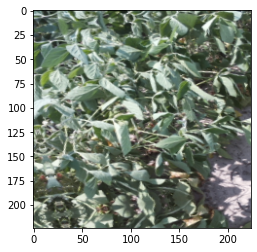

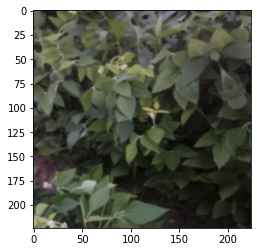

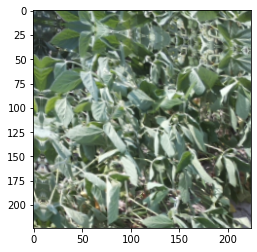

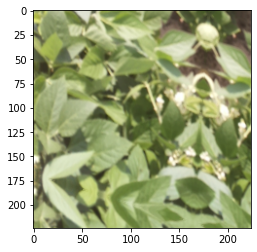

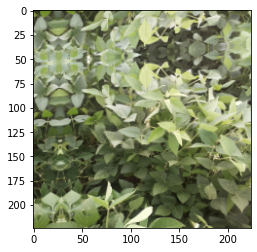

In [0]:
# View Generated Images
print(len(data_folds))
f = data_folds[random.randint(0,len(data_folds)-1)]
images = f[0]
print(images.shape)
print(len(f[1]))
for i in range(5):
  index = random.randint(0,images.shape[0] - 1)
  image = np.asarray(images[index], dtype=np.uint8)
  plt.figure()
  plt.imshow(image)
  print(f[1][index])


In [0]:
# Train Model

import keras
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model_list = []
model_histories = []
confusion_matrices = []
classification_reports = []
for i in range(len(data_folds)):
  print("Training Next Fold")
  validation_set = tuple(data_folds[i])
  print("validation images shape: {}".format(validation_set[0].shape))
  print("validation labels shape: {}".format(np.asarray(validation_set[1]).shape))
  training_set = list(data_folds)
  del training_set[i]
  training_images = None
  training_labels = None
  for k in training_set:
    k_images = k[0]
    k_labels = k[1]
    print("fold images shape: {}".format(k_images.shape))

    if training_images is None:
      training_images = k_images
      training_labels = k_labels
    else:
      training_images = np.append(training_images, k_images, axis=0)
      training_labels = np.append(training_labels, k_labels, axis=0)

  print("Training set shape: {}".format(training_images.shape))
  print("Validation set shape: {}".format(validation_set[0].shape))
  model = generate_model()

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse', 'accuracy'])

  history = model.fit(
      x=training_images, 
      y=training_labels,
      epochs=20, 
      use_multiprocessing=True,
      workers=2,
      validation_data=(validation_set[0], np.asarray(validation_set[1]))
  )

  model_list.append(model)
  model_histories.append(history)

  #Generate Confusion Matrix
  val_predictions = model.predict(validation_set[0])
  
  val_predictions = [np.argmax(x) for x in val_predictions]
  labels = [np.where(r==1)[0][0] for r in validation_set[1]]
  confusion_matrices.append(confusion_matrix(np.asarray(labels), val_predictions))
  classification_reports.append(classification_report(labels, val_predictions))
#Save Split Models
for i in range(len(model_list)):
  model.save(model_path + "trained_model-{}-fold.h5".format(i))


Training Next Fold
validation images shape: (1312, 224, 224, 3)
validation labels shape: (1312, 5)
fold images shape: (1310, 224, 224, 3)
fold images shape: (1332, 224, 224, 3)
fold images shape: (1330, 224, 224, 3)
fold images shape: (1306, 224, 224, 3)
Training set shape: (5278, 224, 224, 3)
Validation set shape: (1312, 224, 224, 3)
Epoch 1/20
165/165 [==============================] - 21s 125ms/step - loss: 1.1268 - mse: 0.1169 - accuracy: 0.5495 - val_loss: 0.8096 - val_mse: 0.0892 - val_accuracy: 0.6738
Epoch 2/20
165/165 [==============================] - 19s 115ms/step - loss: 0.8133 - mse: 0.0899 - accuracy: 0.6556 - val_loss: 0.7582 - val_mse: 0.0838 - val_accuracy: 0.7104
Epoch 3/20
165/165 [==============================] - 19s 114ms/step - loss: 0.7195 - mse: 0.0801 - accuracy: 0.7022 - val_loss: 0.7279 - val_mse: 0.0799 - val_accuracy: 0.7210
Epoch 4/20
165/165 [==============================] - 19s 114ms/step - loss: 0.6655 - mse: 0.0748 - accuracy: 0.7230 - val_loss: 0.7

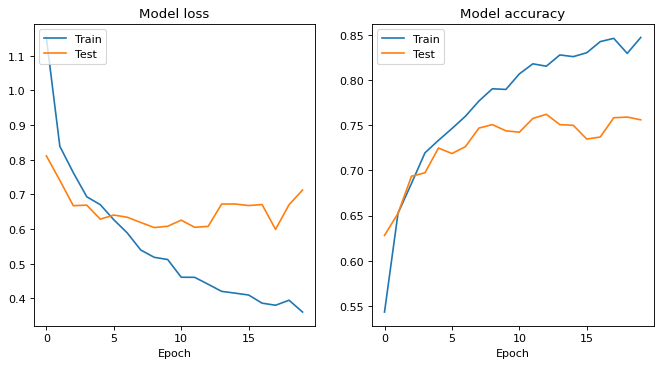

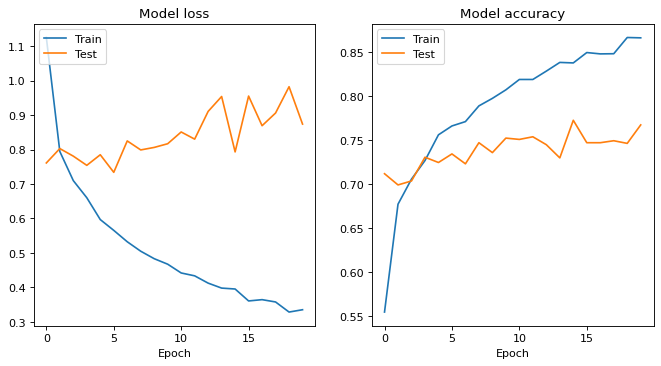

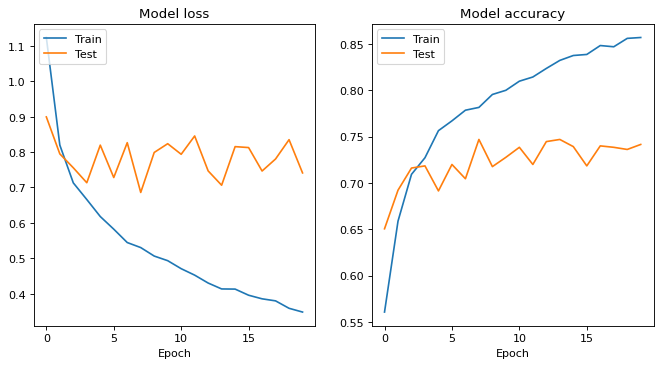

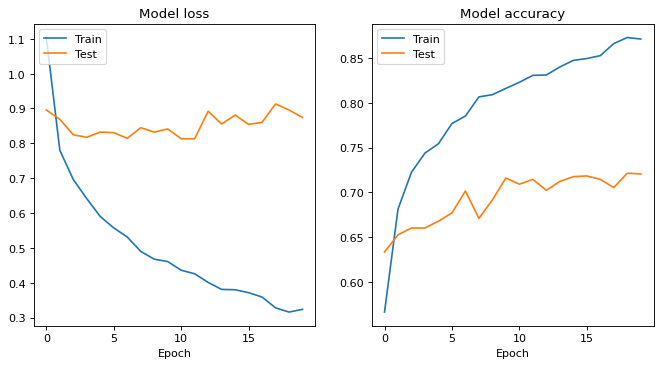

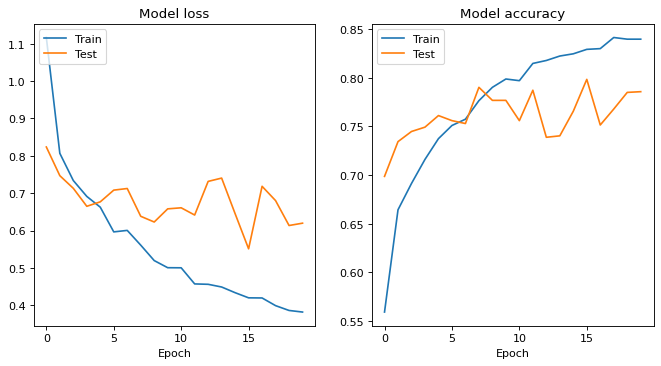

In [0]:
# Plot Fold Curves

import matplotlib.pyplot as plt
for history in model_histories:
  fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

In [0]:
# K Fold Cross Validation Statistics
from pprint import pprint
#End Training statistics
val_losses = [history.history['val_loss'][-1] for history in model_histories]
mean_val_loss = np.mean(val_losses)
std_val_loss = np.std(val_losses)

print("Cross Validation Loss is {0:.4f} w/std {1:.4f}".format(mean_val_loss, std_val_loss)) # include 3 standard deviations for 95% of data points

#End Training statistics
val_accs = [history.history['val_accuracy'][-1] for history in model_histories]
mean_val_acc = np.mean(val_accs)
std_val_acc = np.std(val_accs)

print("Cross Validation Accuracy is {0:.4f} w/std {1:.4f}".format(mean_val_acc, std_val_acc))
print("Confusion Matrices")
for i in range(len(confusion_matrices)):
  pprint(confusion_matrices[i])
  #pprint(classification_reports[i])


Cross Validation Loss is 0.7642 w/std 0.0982
Cross Validation Accuracy is 0.7542 w/std 0.0221
Confusion Matrices
array([[216,  25,  14,   1,   0],
       [ 68, 157,  23,   7,   1],
       [ 69,   6, 160,  37,   0],
       [  1,   3,  30, 212,  26],
       [  0,   0,   0,   9, 247]])
array([[226,  18,   8,   4,   0],
       [ 38, 192,   9,  13,   4],
       [ 57,   9, 141,  27,  24],
       [  1,  14,  35, 186,  42],
       [  0,   1,   1,   6, 278]])
array([[197,  36,  23,   0,   0],
       [ 28, 193,  28,   6,   1],
       [ 39,   5, 172,  48,   0],
       [  0,   0,  15, 226,  23],
       [  0,   1,   1,  81, 173]])
array([[186,  49,  17,   4,   0],
       [ 55, 160,  31,  10,   0],
       [ 25,  36, 130,  67,   0],
       [  2,  15,  31, 221,  15],
       [  0,   5,   0,   4, 247]])
array([[196,  31,  23,   6,   0],
       [ 59, 181,   9,   6,   1],
       [ 32,  50, 182,   8,   0],
       [  1,   4,  38, 239,   2],
       [  0,   3,   2,  13, 258]])


In [0]:
# Pseudo Testing
# Only use when good hyperparameters are found
# Split into hyperparameter set and test set. Force test set to be equally distributed
import random

import keras
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# get filepaths and labels
data_list = csv_to_list(data_root + 'TrainData-C2/TrainAnnotations.csv')
data_list.sort()
data_list = list(reversed(data_list))
test_set_split = 0.3
test_class_size = int(test_set_split*len(data_list)/5)
pseudo_test_set = []
img_class_dict = {
            0:[],
            1:[],
            2:[],
            3:[],
            4:[]
        }

for i in range(len(data_list)):
  img_class_dict[data_list[i][1]].append(data_list[i])


hyperparameter_set = list(data_list)
for key in img_class_dict.keys():
  print(len(img_class_dict[key]))
  for i in range(test_class_size):
    data_tuple = img_class_dict[key][i]
    hyperparameter_set.remove(data_tuple)
    pseudo_test_set.append(data_tuple)
random.shuffle(hyperparameter_set)
random.shuffle(pseudo_test_set)
print(pseudo_test_set)
combined_augment_args = {
            'featurewise_center': False, # Default False
            'samplewise_center': False, # Default False
            'featurewise_std_normalization': False, # Default False
            'samplewise_std_normalization': False, # Default False
            'zca_whitening': False, # Default False
            'zca_epsilon': 1e-06, # Default 1e-6
            'rotation_range': 30,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'brightness_range': None, # Default None
            'shear_range': 10.0,
            'zoom_range': 0.2,
            'channel_shift_range': 0.0,
            'fill_mode': 'reflect', # Default 'nearest'
            'cval': 0.0,
            'horizontal_flip': True, # Default False
            'vertical_flip': False, # Default False
            'rescale': None # Default None
        }
pseudo_test_augment_args = {
            'featurewise_center': False, # Default False
            'samplewise_center': False, # Default False
            'featurewise_std_normalization': False, # Default False
            'samplewise_std_normalization': False, # Default False
            'zca_whitening': False, # Default False
            'zca_epsilon': 1e-06, # Default 1e-6
            'rotation_range': 50,
            'width_shift_range': 0.0,
            'height_shift_range': 0.0,
            'brightness_range': None, # Default None
            'shear_range': 30,
            'zoom_range': 0.2,
            'channel_shift_range': 0.0,
            'fill_mode': 'reflect', # Default 'nearest'
            'cval': 0.0,
            'horizontal_flip': True, # Default False
            'vertical_flip': True, # Default False
            'rescale': None, # Default None
        }
# Train Full Model with hyperparameter set data
combined_images, combined_labels = augment_pipeline(hyperparameter_set, combined_augment_args, gaussian_noise=False ,random_crop=True, num_random_crops=10, augment = True, images_per_class=1024)

# Raise the difficulty of the test set
pseudo_test_images, pseudo_test_labels = augment_pipeline(pseudo_test_set, pseudo_test_augment_args, augment=True, random_crop=True, gaussian_noise=False)


488
329
130
131
197
[['025874.jpg', 1], ['025405.jpg', 1], ['014126.jpg', 2], ['017009.jpg', 3], ['028696.jpg', 4], ['018698.jpg', 0], ['018876.jpg', 3], ['028054.jpg', 1], ['019064.jpg', 3], ['013249.jpg', 3], ['027517.jpg', 4], ['012482.jpg', 3], ['015736.jpg', 3], ['013430.jpg', 3], ['010723.jpg', 3], ['025139.jpg', 4], ['012677.jpg', 2], ['024382.jpg', 1], ['028114.jpg', 1], ['013773.jpg', 2], ['015952.jpg', 3], ['017283.jpg', 0], ['009217.jpg', 2], ['026412.jpg', 1], ['017955.jpg', 3], ['010908.jpg', 3], ['012515.jpg', 3], ['018937.jpg', 0], ['027958.jpg', 1], ['024718.jpg', 1], ['017024.jpg', 2], ['027409.jpg', 1], ['027563.jpg', 1], ['027630.jpg', 4], ['014500.jpg', 3], ['018689.jpg', 0], ['018172.jpg', 0], ['018880.jpg', 0], ['017683.jpg', 0], ['016015.jpg', 2], ['008208.jpg', 3], ['012089.jpg', 3], ['019026.jpg', 0], ['016196.jpg', 2], ['024674.jpg', 1], ['014228.jpg', 2], ['018825.jpg', 0], ['017152.jpg', 0], ['027187.jpg', 4], ['012099.jpg', 3], ['015094.jpg', 2], ['016116.j

Epoch 1/15
162/162 [==============================] - 25s 152ms/step - loss: 1.1998 - mse: 0.1252 - accuracy: 0.5054 - val_loss: 0.9280 - val_mse: 0.1023 - val_accuracy: 0.6185
Epoch 2/15
162/162 [==============================] - 23s 140ms/step - loss: 0.9180 - mse: 0.1022 - accuracy: 0.6024 - val_loss: 0.8989 - val_mse: 0.0992 - val_accuracy: 0.6222
Epoch 3/15
162/162 [==============================] - 23s 140ms/step - loss: 0.8518 - mse: 0.0949 - accuracy: 0.6327 - val_loss: 0.8935 - val_mse: 0.0971 - val_accuracy: 0.6411
Epoch 4/15
162/162 [==============================] - 23s 140ms/step - loss: 0.7962 - mse: 0.0893 - accuracy: 0.6655 - val_loss: 0.9787 - val_mse: 0.1035 - val_accuracy: 0.6241
Epoch 5/15
162/162 [==============================] - 23s 140ms/step - loss: 0.7531 - mse: 0.0860 - accuracy: 0.6799 - val_loss: 1.0197 - val_mse: 0.1055 - val_accuracy: 0.6015
Epoch 6/15
162/162 [==============================] - 23s 140ms/step - loss: 0.7248 - mse: 0.0835 - accuracy: 0.687

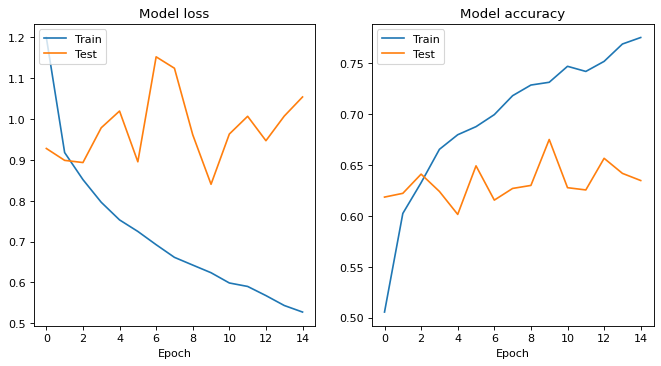

In [0]:
# Train 
model = generate_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse', 'accuracy'])

history = model.fit(
    x=combined_images, 
    y=combined_labels,
    epochs=15, 
    use_multiprocessing=True,
    validation_data=(pseudo_test_images, pseudo_test_labels),
    workers=2,
)

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


val_predictions = model.predict(pseudo_test_images)

val_predictions = [np.argmax(x) for x in val_predictions]
labels = [np.where(r==1)[0][0] for r in pseudo_test_labels]
print(confusion_matrix(np.asarray(labels), val_predictions))
print(classification_report(labels, val_predictions))



In [0]:
#Load Testing Data
from os import listdir, walk
from os.path import isfile
import cv2
import numpy as np


test_filepaths = []
for (dirpath, directories, filepaths) in walk(test_data_path):
  test_filepaths.extend([test_data_path + f for f in filepaths])
test_filepaths.sort()
print(test_filepaths)
test_images = [cv2.imread(f) for f in test_filepaths]
test_images = [cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC) for image in test_images]

test_images = np.array(test_images)

['/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020031.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020244.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020446.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020597.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020693.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020720.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020783.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020795.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_CompetitionData/TestData/020810.jpg', '/content/drive/My Drive/ECE 542 Competition Project/ECE542_sp20_Competi

In [0]:
# Train Model with all data
data_list = csv_to_list(data_root + 'TrainData-C2/TrainAnnotations.csv')

combined_augment_args = {
            'featurewise_center': False, # Default False
            'samplewise_center': False, # Default False
            'featurewise_std_normalization': False, # Default False
            'samplewise_std_normalization': False, # Default False
            'zca_whitening': False, # Default False
            'zca_epsilon': 1e-06, # Default 1e-6
            'rotation_range': 30,
            'width_shift_range': 0.0,
            'height_shift_range': 0.0,
            'brightness_range': None, # Default None
            'shear_range': 30.0,
            'zoom_range': 0.2,
            'channel_shift_range': 0.0,
            'fill_mode': 'reflect', # Default 'nearest'
            'cval': 0.0,
            'horizontal_flip': True, # Default False
            'vertical_flip': False, # Default False
            'rescale': None # Default None
        }

# Train Full Model with hyperparameter set data
all_images, all_labels = augment_pipeline(data_list, combined_augment_args, random_crop=False, augment = True, images_per_class=1024)

model = generate_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse', 'accuracy'])

history = model.fit(
    x=all_images,
    y=all_labels,
    epochs=10, 
    use_multiprocessing=True,
    workers=2,
)

Gen Size: 1040
Gen Size: 1051
Gen Size: 1038
Gen Size: 1045
Gen Size: 1049
Epoch 1/10
164/164 [==============================] - 15s 94ms/step - loss: 1.1407 - mse: 0.1159 - accuracy: 0.5606
Epoch 2/10
164/164 [==============================] - 15s 93ms/step - loss: 0.8338 - mse: 0.0902 - accuracy: 0.6609
Epoch 3/10
164/164 [==============================] - 15s 93ms/step - loss: 0.7442 - mse: 0.0812 - accuracy: 0.7071
Epoch 4/10
164/164 [==============================] - 15s 93ms/step - loss: 0.6605 - mse: 0.0731 - accuracy: 0.7295
Epoch 5/10
164/164 [==============================] - 15s 93ms/step - loss: 0.6225 - mse: 0.0696 - accuracy: 0.7469
Epoch 6/10
164/164 [==============================] - 15s 93ms/step - loss: 0.6005 - mse: 0.0675 - accuracy: 0.7595
Epoch 7/10
164/164 [==============================] - 15s 92ms/step - loss: 0.5742 - mse: 0.0642 - accuracy: 0.7657
Epoch 8/10
164/164 [==============================] - 15s 93ms/step - loss: 0.5352 - mse: 0.0604 - accuracy: 0.78

In [0]:
# Load Trained model
from keras.models import load_model

trained_model_path = None
if colab:
    trained_model_path = '/content/gdrive/My Drive/ECE 542 Competition Project/models/trial-' + str(trial) + '/trained_model.h5'
else:
    trained_model_path = './models/trial-' + str(trial) + '/trained_model.h5'

test_model = load_model(trained_model_path)

OSError: ignored

In [0]:
# Get Test Predictions
import csv

test_model = model


predictions = test_model.predict(test_images)
predictions = [np.argmax(prediction) for prediction in predictions]
predictions = to_categorical(predictions)

with open(predict_save_path, 'w') as f:
  csv_writer = csv.writer(f, delimiter=',')
  csv_writer.writerows(predictions)